f## Common Libraries

In [99]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json, os, gzip
import glob
import math
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering, MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, Normalizer
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.datasets import make_moons, make_circles, make_blobs

Constants

In [102]:
FIGURE_SAVE_PATH: str = "./figures"
TABLE_SAVE_PATH: str = "./table_results"
DATASET_PATH: str = "./datasets"
DATASET_SAMPLE_NAME = "reproducible_dataset"
FILES:list[str] = ["dblp-ref-0.json", "dblp-ref-1.json", "dblp-ref-2.json", "dblp-ref-3.json"]

# Sampling length our dataset is too big this makes it more manageable to work with
# 2000 per year is a good representation of our dataset
DEV_MODE:bool = False
SAMPLES_PER_YEAR:int = 250 if DEV_MODE else 2000
# For Reproducibility
SAMPLE_SEED = 42

# Helper function to split sampled dataset into chunks to not exceed githubs 100mb file limit
def load_split_dataframe(base_path, base_name):
    pattern = os.path.join(base_path, f"{base_name}_part*.pkl")
    files = sorted(glob.glob(pattern))  # sorted ensures correct row order

    if not files:
        raise FileNotFoundError(f"No files matching {pattern}")

    parts = [pd.read_pickle(f) for f in files]
    df = pd.concat(parts, axis=0)

    return df

def save_split_dataframe(df, base_path, base_name, n_parts=4):
    n = len(df)
    part_size = math.ceil(n / n_parts)

    os.makedirs(base_path, exist_ok=True)

    for i in range(n_parts):
        start = i * part_size
        end = min((i + 1) * part_size, n)
        part = df.iloc[start:end]  # preserves index + column order

        filename = os.path.join(base_path, f"{base_name}_part{i:02d}.pkl")
        part.to_pickle(filename)
        print(f"Saved rows [{start}:{end}) to {filename}")


### Load the Dataset

In [4]:
# loading data
def read_json_lines(path):
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

def load_all(files=FILES):
    rows = []
    for fp in files:
        for rec in read_json_lines(f"./datasets/{fp}"):
            rows.append(rec)
    return pd.DataFrame(rows)

df = load_all()

as_type = {
    "year": "category",
    "n_citation": np.uint32,
}

df = df.astype(as_type)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3079007 entries, 0 to 3079006
Data columns (total 8 columns):
 #   Column      Dtype   
---  ------      -----   
 0   abstract    object  
 1   authors     object  
 2   n_citation  uint32  
 3   references  object  
 4   title       object  
 5   venue       object  
 6   year        category
 7   id          object  
dtypes: category(1), object(6), uint32(1)
memory usage: 155.6+ MB


In [6]:
df.head(10)

abstract  \
0  The purpose of this study is to develop a lear...   
1  This paper describes the design and implementa...   
2  This article applied GARCH model instead AR or...   
3                                                NaN   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7                                                NaN   
8                                                NaN   
9                                                NaN   

                                             authors  n_citation  \
0  [Makoto Satoh, Ryo Muramatsu, Mizue Kayama, Ka...           0   
1                        [Gareth Beale, Graeme Earl]          50   
2  [Altaf Hossain, Faisal Zaman, Mohammed Nasser,...          50   
3  [Jea-Bum Park, Byungmok Kim, Jian Shen, Sun-Yo...           0   
4                [Giovanna Guerrini, Isabella Merlo]           2   
5  [Rafael Álvarez, Leandro Tortosa, José-Francis...           0   
6               [Jovan Dj. Golic, Guglielmo Morgari]           2   
7   [Guzin Ulutas, Mustafa Ulutas, Vasif V. Nabiyev]           0   
8               [Pranay Chaudhuri, Hussein Thompson]           0   
9               [Dominik Szajerman, Adam Jurczyński]           0   

                                          references  \
0  [51c7e02e-f5ed-431a-8cf5-f761f266d4be, 69b625b...   
1  [10482dd3-4642-4193-842f-85f3b70fcf65, 3133714...   
2  [2d84c0f2-e656-4ce7-b018-90eda1c132fe, a083a1b...   
3  [8c78e4b0-632b-4293-b491-85b1976675e6, 9cdc54f...   
4                                                NaN   
5                                                NaN   
6                                                NaN   
7  [5626736c-e434-4e2d-8405-54940fab88ab, 8e87e87...   
8                                                NaN   
9  [3fcd7cdc-20e6-4ea3-a41c-db126fcc5cfe, bf3a11c...   

                                               title  \
0  Preliminary Design of a Network Protocol Learn...   
1  A methodology for the physically accurate visu...   
2  Comparison of GARCH, Neural Network and Suppor...   
3  Development of Remote Monitoring and Control D...   
4  Reasonig about Set-Oriented Methods in Object ...   
5  COMPARING GNG3D AND QUADRIC ERROR METRICS METH...   
6                Vectorial fast correlation attacks.   
7  Improved Secret Image Sharing Method By Encodi...   
8  A Self-Stabilizing Algorithm for Finding the C...   
9  Fur Visualisation for Computer Game Engines an...   

                                               venue  year  \
0  international conference on human-computer int...  2013   
1            visual analytics science and technology  2011   
2       pattern recognition and machine intelligence  2009   
3                                                     2011   
4                                                     1998   
5  international conference on computer graphics ...  2009   
6                                                     2004   
7  international symposium on computer and inform...  2011   
8  parallel and distributed processing techniques...  2003   
9  international conference on computer vision an...  2014   

                                     id  
0  00127ee2-cb05-48ce-bc49-9de556b93346  
1  001c58d3-26ad-46b3-ab3a-c1e557d16821  
2  001c8744-73c4-4b04-9364-22d31a10dbf1  
3  00338203-9eb3-40c5-9f31-cbac73a519ec  
4  0040b022-1472-4f70-a753-74832df65266  
5  005ce28f-ed77-4e97-afdc-a296137186a1  
6  00638a94-23bf-4fa6-b5ce-40d799c65da7  
7  00701b05-684f-45f9-b281-425abfec482c  
8  00745041-3636-4d18-bbec-783c4278c40d  
9  00964544-cbe2-4da9-bb5a-03333160eb34

## Task 1: Preprocessing & Feature Generation

#### Preprocess & Sample The Dataset

In [5]:
# Drop Missing years and titles
df = df[(df["title"].notna()) & (df["year"].notna())]

# Filter out rare venues
venue_counts = df["venue"].value_counts()
df = df[df["venue"].isin(venue_counts[venue_counts >= 50].index)]

# Filter out missing venues
print(f"Removing {len(df[df['venue'].str.strip() == ""])} papers with missing venues")
df = df[df['venue'].str.strip() != ""]

# as we saw later when doing simple EDA the papers with n_citation = 50 are likely a data scraping error as it shift the distribution outside a power like distribution
# SEE:
# https://link.springer.com/article/10.1007/s100510050359
df_clean_source = df[df['n_citation'] != 50]

print(f"Sampling {SAMPLES_PER_YEAR} papers per year...")


sampled_df = (
    df_clean_source.groupby('year', observed = True)
    .apply(lambda x : x.sample(
        min(len(x), SAMPLES_PER_YEAR),
        random_state = SAMPLE_SEED
    ), include_groups = False)
    .reset_index(level = 'year')
)

# Handle normalizing or fixing the dataset on the sample since it will be less
# computationally expensive

# Replace missing abstracts with empty string
sampled_df["abstract"] = sampled_df["abstract"].fillna("")

# Combine title and abstract as one feature
sampled_df['text'] = sampled_df['title'] + " " + sampled_df['abstract']

# Normalize Text
sampled_df["title"] = sampled_df["title"].str.lower()
sampled_df["abstract"] = sampled_df["abstract"].str.lower()

# Reset Index so df rows align with matrix rows (0 to N)
sampled_df = sampled_df.reset_index(drop = True)

print(f"Original Shape: {df.shape}")
print(f"Sampled Shape: {sampled_df.shape}")
sampled_df.head()


Removing 506699 papers with missing venues
Sampling 2000 papers per year...
Original Shape: (2556505, 8)
Sampled Shape: (91812, 9)


year abstract              authors  n_citation  \
0  1936                 [W. V. Quine]          19   
1  1936           [Frederic B. Fitch]          24   
2  1936                [Emil L. Post]         367   
3  1936           [J. Barkley Rosser]           1   
4  1936               [Alonzo Church]         150   

                               references  \
0                                     NaN   
1                                      []   
2                                      []   
3                                     NaN   
4  [c45bdb20-3d36-4d7d-8a83-203e3d3bff9e]   

                                               title  \
0                      toward a calculus of concepts   
1  a system of formal logic without an analogue t...   
2        finite combinatory processes--formulation 1   
3      constructibility as a criterion for existence   
4   correction to a note on the entscheidungsproblem   

                       venue                                    id  \
0  Journal of Symbolic Logic  566fc941-6ba6-41ab-b579-ad3d7fe4ca27   
1  Journal of Symbolic Logic  62c68236-b9e5-44dd-b299-e0d03c3e7bf4   
2  Journal of Symbolic Logic  e254cbb5-e369-49dc-97a2-4d60eaea27dd   
3  Journal of Symbolic Logic  8581f824-2333-4b5f-b277-a4020281a7f8   
4  Journal of Symbolic Logic  c5c32b04-0a67-4cd6-b135-3f65ab87e33b   

                                                text  
0                     Toward a calculus of concepts   
1  A System of Formal Logic without an Analogue t...  
2       Finite Combinatory Processes--Formulation 1   
3     Constructibility as a Criterion for Existence   
4  Correction to a Note on the Entscheidungsproblem

### Generate Black Box Features
These are for our clustering and classification tasks in our proposal.

#### TF-IDF Pipeline

In [6]:
# Run TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# In task 2 (topic clustering) german papers kept prevalent as a separate cluster
# Instead of clustering-and-dropping, we just drop rows containing common German stop words.
# This is instant and stops them from popping up again.
german_indicators = [
    " der ", " die ", " und ", " von ", " für ", " mit ",
    " ist ", " des ", " ein ", " eine ", " ich ",
    " vom ", " doch ", " sowie ", " zur ", " zum "
]
mask_german = sampled_df['text'].str.contains('|'.join(german_indicators), case=False, regex=True)
print(f"Removing {mask_german.sum()} German papers via keyword filter...")
sampled_df = sampled_df[~mask_german].reset_index(drop=True)


# Also with just the basic stop words it forms huge clusters with 40,000+ papers this is in an attempt to break this up
my_stop_words = list(TfidfVectorizer(stop_words="english").get_stop_words())

my_stop_words += [
    'based', 'using', 'method', 'paper', 'results', 'problem', 'time',
    'approach', 'new', 'proposed', 'algorithm', 'study', 'analysis',
    'data', 'use', 'number', 'systems', 'system', 'model', 'models',
    'design', 'research', 'development'
]

print("Vectorizing....")
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words=my_stop_words,
    ngram_range=(1,2)
)

X_tfidf = tfidf.fit_transform(sampled_df["text"])

Removing 1621 German papers via keyword filter...
Vectorizing....


#Important: You only really need to run this once after that its meaningless

We test here to find the optimal n_dimension by trying to maximize the silhoutte score for sparse text datasets its usually advised for the n_dimension to be around 50-350



=== Testing 50 components ===
Cumulative explained variance: 0.0934
Silhouette score: 0.0539

=== Testing 75 components ===
Cumulative explained variance: 0.1227
Silhouette score: 0.0458

=== Testing 100 components ===
Cumulative explained variance: 0.1483
Silhouette score: 0.0494

=== Testing 150 components ===
Cumulative explained variance: 0.1930
Silhouette score: 0.0394

=== Testing 200 components ===
Cumulative explained variance: 0.2315
Silhouette score: 0.0197

=== Testing 250 components ===
Cumulative explained variance: 0.2654
Silhouette score: 0.0257

=== Testing 300 components ===
Cumulative explained variance: 0.2957
Silhouette score: 0.0306

=== Testing 350 components ===
Cumulative explained variance: 0.3235
Silhouette score: 0.0150


n_components  cum_explained_var  silhouette
0            50           0.093403    0.053905
1            75           0.122708    0.045783
2           100           0.148299    0.049421
3           150           0.193046    0.039359
4           200           0.231482    0.019693
5           250           0.265358    0.025674
6           300           0.295725    0.030606
7           350           0.323537    0.014976

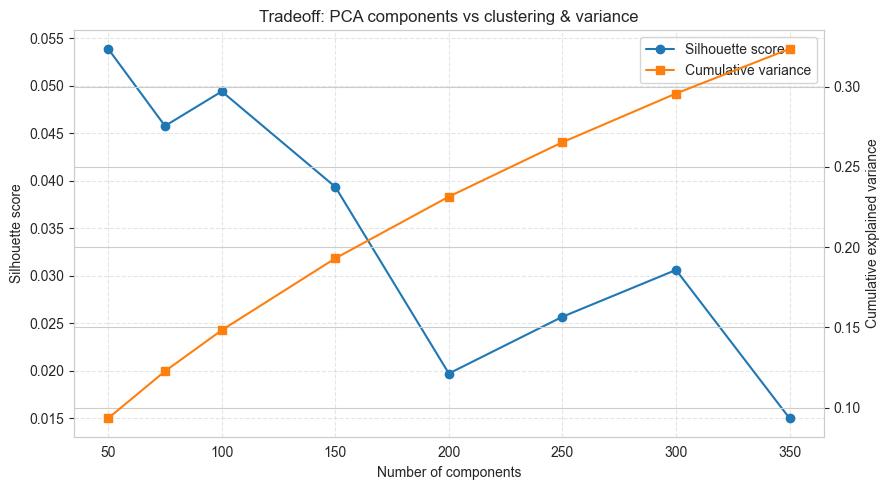

In [37]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt


components_to_test =  [50, 75, 100, 150, 200, 250, 300, 350]
n_clusters = 9
max_sil_samples = 5000   # subsample for silhouette to keep it fast

results = []

for n_comp in components_to_test:
    print(f"\n=== Testing {n_comp} components ===")

    svd = TruncatedSVD(n_components=n_comp, random_state=42)
    X_red = svd.fit_transform(X_tfidf)

    cum_var = svd.explained_variance_ratio_.sum()
    print(f"Cumulative explained variance: {cum_var:.4f}")

    # K-means on reduced data
    km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
    labels = km.fit_predict(X_red)

    # Subsample for silhouette (it’s O(n^2))
    if X_red.shape[0] > max_sil_samples:
        idx = np.random.choice(X_red.shape[0], max_sil_samples, replace=False)
        sil = silhouette_score(X_red[idx], labels[idx])
    else:
        sil = silhouette_score(X_red, labels)

    print(f"Silhouette score: {sil:.4f}")

    results.append({
        "n_components": n_comp,
        "cum_explained_var": cum_var,
        "silhouette": sil
    })

results_df = pd.DataFrame(results)
display(results_df)

# plot the tradeoff
fig, ax1 = plt.subplots(figsize=(9,5))

ax1.plot(results_df["n_components"], results_df["silhouette"],
         marker="o", label="Silhouette score")
ax1.set_xlabel("Number of components")
ax1.set_ylabel("Silhouette score")
ax1.grid(True, linestyle="--", alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(results_df["n_components"], results_df["cum_explained_var"],
         marker="s", color="tab:orange", label="Cumulative variance")
ax2.set_ylabel("Cumulative explained variance")

# Combine legends
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="best")

plt.title("Tradeoff: PCA components vs clustering & variance")
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/pca_ncomponent_tradeoff.png")
plt.show()


#### PCA Preprocess Pipeline

In [14]:
# PCA Feature Pipeline
from sklearn.decomposition import PCA

# Check if PCA columns already exist and drop them so we don't get duplicates
cols_to_drop = [c for c in sampled_df.columns if c.startswith('pca_') or c == 'cluster']
sampled_df = sampled_df.drop(columns=cols_to_drop, errors='ignore')

# Run PCA
OPTIMAL_N_COMPONENT = 50
# See above plot to find the optimal n_components
pca = PCA(n_components=OPTIMAL_N_COMPONENT, random_state=SAMPLE_SEED)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Create a df from PCA results and attach it to sampled_df
pca_cols = [f"pca_{i}" for i in range(OPTIMAL_N_COMPONENT)]
pca_df = pd.DataFrame(X_pca, columns=pca_cols)
sampled_df = pd.concat([sampled_df, pca_df], axis=1)

# Author and Venue Embeddings
# Venue embeddings
venue_emb = sampled_df.groupby("venue")[pca_cols].mean()

# Author embeddings
authors_exploded = []
authors_emb = []
authors_exploded = sampled_df.explode('authors')
author_emb = authors_exploded.groupby('authors')[pca_cols].mean()

#### Generate Interpretable Features
These are the metadata features for trend analysis and network analysis

In [15]:
# Number of Authors (Collaboration Size)
sampled_df['num_authors'] = sampled_df['authors'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Title Length (Character Count)
sampled_df['title_length'] = sampled_df['title'].apply(lambda x: len(str(x)))

# Number of References (How many papers this paper cites)
sampled_df['num_refs'] = sampled_df['references'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Citation Velocity (Citations per year)
sampled_df['citation_velocity'] = sampled_df['n_citation'] / (2018 - sampled_df['year'].astype(int) + 1)
print(sampled_df['citation_velocity'].max())

# Change the types as well to reduce memory
as_type = {
    "num_authors": "category",
    "title_length": np.uint16,
    "num_refs": np.uint8,
    "citation_velocity": np.float32,
}

sampled_df[["title", 'year', 'num_authors', 'num_refs', 'citation_velocity']].head()

1662.4


title  year  num_authors  \
0                      toward a calculus of concepts  1936            1   
1  a system of formal logic without an analogue t...  1936            1   
2        finite combinatory processes--formulation 1  1936            1   
3      constructibility as a criterion for existence  1936            1   
4   correction to a note on the entscheidungsproblem  1936            1   

   num_refs  citation_velocity  
0         0           0.228916  
1         0           0.289157  
2         0           4.421687  
3         0           0.012048  
4         1           1.807229

For reproducibility and to reduce overhead of loading the dataset save it

In [30]:
# Pickle format
sampled_df.to_pickle(f"{DATASET_PATH}/reproducible_dataset.pkl")

Load saved sampled dataset

In [44]:
sampled_df = pd.read_pickle(f"{DATASET_PATH}/reproducible_dataset.pkl")
sampled_df.head(10)

year abstract              authors  n_citation  \
0  1936                 [W. V. Quine]          19   
1  1936           [Frederic B. Fitch]          24   
2  1936                [Emil L. Post]         367   
3  1936           [J. Barkley Rosser]           1   
4  1936               [Alonzo Church]         150   
5  1936               [Alonzo Church]         949   
6  1937                [A. M. Turing]         552   
7  1937                [A. M. Turing]           4   
8  1937             [B. A. Bernstein]           1   
9  1937            [Haskell B. Curry]           6   

                               references  \
0                                     NaN   
1                                      []   
2                                      []   
3                                     NaN   
4  [c45bdb20-3d36-4d7d-8a83-203e3d3bff9e]   
5                                      []   
6                                      []   
7                                      []   
8                                      []   
9                                     NaN   

                                               title  \
0                      toward a calculus of concepts   
1  a system of formal logic without an analogue t...   
2        finite combinatory processes--formulation 1   
3      constructibility as a criterion for existence   
4   correction to a note on the entscheidungsproblem   
5                 a note on the entscheidungsproblem   
6                   computability and λ-definability   
7                   the þ-function in λ-k-conversion   
8  remark on nicod's reduction of principia mathe...   
9  on the use of dots as brackets in logical expr...   

                       venue                                    id  \
0  Journal of Symbolic Logic  566fc941-6ba6-41ab-b579-ad3d7fe4ca27   
1  Journal of Symbolic Logic  62c68236-b9e5-44dd-b299-e0d03c3e7bf4   
2  Journal of Symbolic Logic  e254cbb5-e369-49dc-97a2-4d60eaea27dd   
3  Journal of Symbolic Logic  8581f824-2333-4b5f-b277-a4020281a7f8   
4  Journal of Symbolic Logic  c5c32b04-0a67-4cd6-b135-3f65ab87e33b   
5  Journal of Symbolic Logic  c45bdb20-3d36-4d7d-8a83-203e3d3bff9e   
6  Journal of Symbolic Logic  0ae42956-0f17-4fd8-9453-baf2d0961c1a   
7  Journal of Symbolic Logic  2c4c81e4-53d5-43d9-b82f-a230e22c2378   
8  Journal of Symbolic Logic  fb61c692-822a-4541-9986-6ad4bf485251   
9  Journal of Symbolic Logic  41f5e18d-db3d-4649-8e2e-c9f3d3e36196   

                                                text  num_authors  ...  \
0                     Toward a calculus of concepts             1  ...   
1  A System of Formal Logic without an Analogue t...            1  ...   
2       Finite Combinatory Processes--Formulation 1             1  ...   
3     Constructibility as a Criterion for Existence             1  ...   
4  Correction to a Note on the Entscheidungsproblem             1  ...   
5                A Note on the Entscheidungsproblem             1  ...   
6                  Computability and λ-definability             1  ...   
7                  The þ-function in λ-K-conversion             1  ...   
8  Remark on Nicod's Reduction of Principia Mathe...            1  ...   
9  On the Use of Dots as Brackets in Logical Expr...            1  ...   

     pca_42    pca_43    pca_44    pca_45    pca_46    pca_47    pca_48  \
0 -0.004447 -0.003523  0.005803  0.005651  0.002952  0.017808  0.008910   
1  0.028468  0.020519  0.018740  0.003789  0.019213  0.006718 -0.022645   
2  0.028557  0.084147  0.034929  0.009790 -0.012288 -0.048536  0.038909   
3  0.004385 -0.003634  0.001965  0.014097 -0.000098  0.001151  0.002429   
4  0.026840 -0.064592 -0.028100  0.068239 -0.033541 -0.083212  0.039810   
5  0.026409 -0.100998 -0.028361  0.106545 -0.053481 -0.105636  0.066998   
6  0.010195  0.002978  0.001370  0.000237  0.003440 -0.000305 -0.001626   
7 -0.011272  0.020952  0.007020 -0.024866  0.049571 -0.020171  0.016983   
8  0.024520  0.012880  0.004953  0.007631  0.

### EDA Validation for our cleaned sampled dataset

To see if our preprocessing pipeline generated quality data

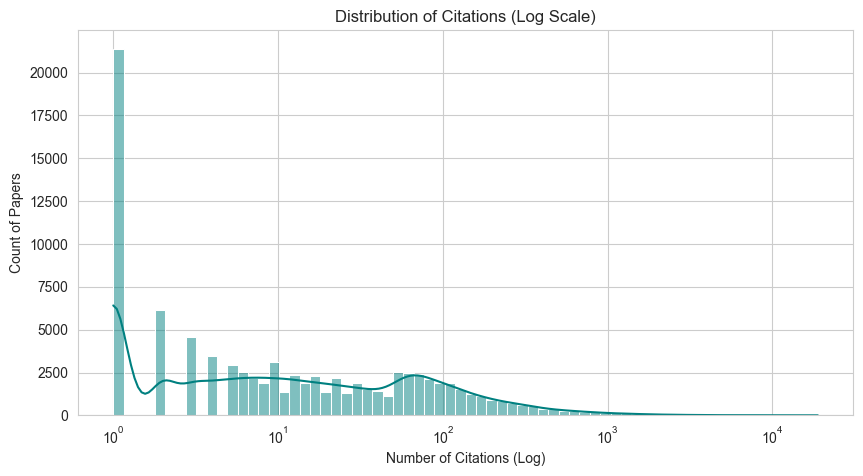

C:\Users\X0\AppData\Local\Temp\ipykernel_28108\299753942.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  auth_trend = sampled_df.groupby('year')['num_authors'].mean().reset_index()


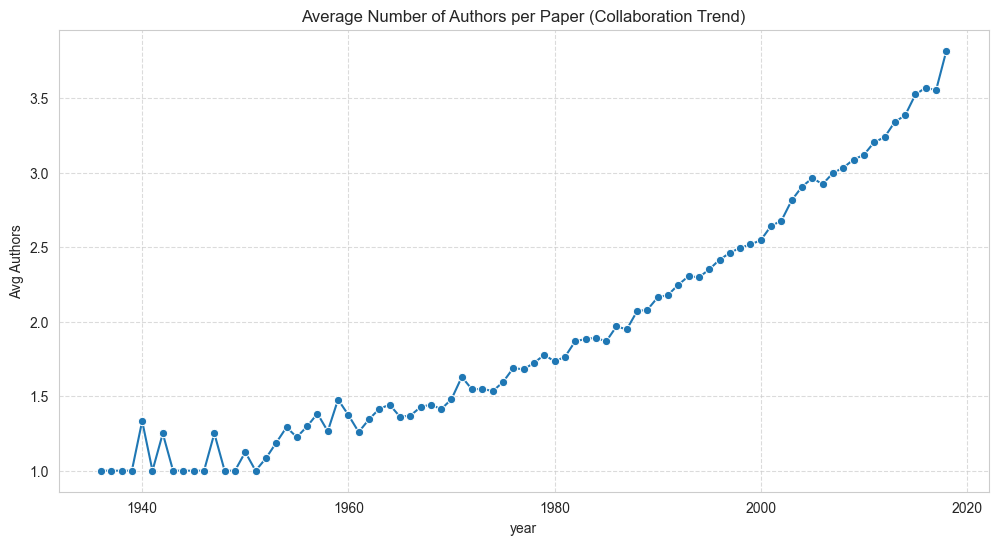

C:\Users\X0\AppData\Local\Temp\ipykernel_28108\299753942.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='venue', data=sampled_df[sampled_df['venue'].isin(top_venues)], order=top_venues, palette='viridis')


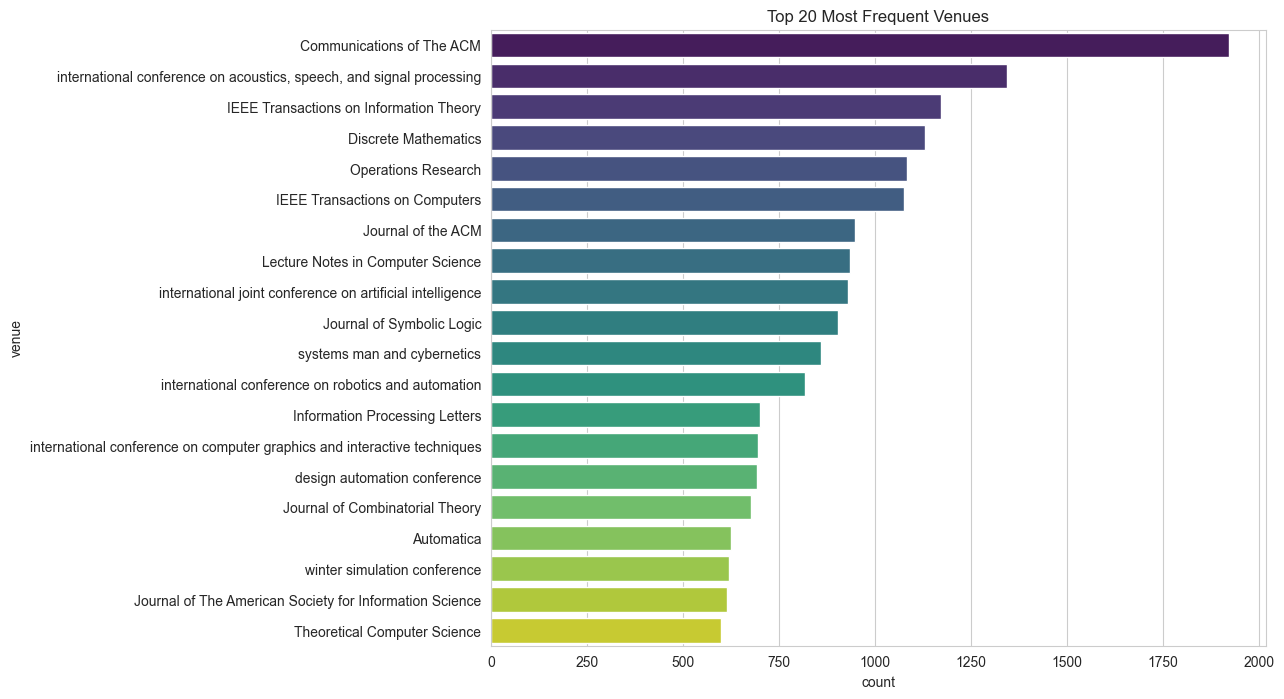

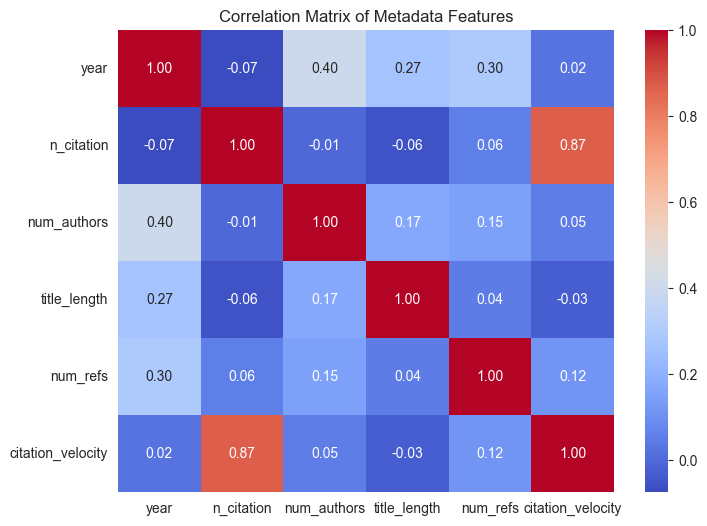

In [18]:
# The "Power Law" Check (Citation Distribution)
# See https://link.springer.com/article/10.1007/s100510050359
# This is now done above in the preprocessing check
# Preprocessed above to remove n_citation = 50 outlier
# ARTIFACT_VAL = 50
# clean_df = sampled_df[sampled_df['n_citation'] != ARTIFACT_VAL]

plt.figure(figsize=(10,5))
sns.histplot(sampled_df['n_citation'] + 1, log_scale=True, kde=True, color='teal')
plt.title('Distribution of Citations (Log Scale)')
plt.xlabel('Number of Citations (Log)')
plt.ylabel('Count of Papers')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_citation_distribution.png")
plt.show()

plt.figure(figsize=(12, 6))
# Group by year and get mean authors
auth_trend = sampled_df.groupby('year')['num_authors'].mean().reset_index()
sns.lineplot(data=auth_trend, x='year', y='num_authors', marker='o')
plt.title('Average Number of Authors per Paper (Collaboration Trend)')
plt.ylabel('Avg Authors')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_collaboration_trend.png")
plt.show()

plt.figure(figsize=(10, 8))
# Get top 20 venues
top_venues = sampled_df['venue'].value_counts().nlargest(20).index
# Filter data to only those venues for plotting
sns.countplot(y='venue', data=sampled_df[sampled_df['venue'].isin(top_venues)], order=top_venues, palette='viridis')
plt.title('Top 20 Most Frequent Venues')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_top_venues.png")
plt.show()



# Select only numeric metadata
meta_cols = ['year', 'n_citation', 'num_authors', 'title_length', 'num_refs', 'citation_velocity']

plt.figure(figsize=(8, 6))
sns.heatmap(sampled_df[meta_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Metadata Features')
plt.savefig(f"{FIGURE_SAVE_PATH}/eda_corr_matrix.png")
plt.show()


## Task 2: Topic Clustering

#### K-Means Pipeline

Important: You really only need to run this once

This is in an attempt to find an optimal low k in order to still make the clusters interpretable.

Testing k values (6-31)...
k=6: Silhouette=0.0456  Inertia=7398.8335
k=7: Silhouette=0.0615  Inertia=7288.7316
k=8: Silhouette=0.0721  Inertia=7101.7479
k=9: Silhouette=0.0594  Inertia=6985.3127
k=10: Silhouette=0.0920  Inertia=6884.1415
k=11: Silhouette=0.0714  Inertia=6717.9854
k=12: Silhouette=0.0651  Inertia=6560.8027
k=13: Silhouette=0.0706  Inertia=6480.6233
k=14: Silhouette=0.0742  Inertia=6361.1391
k=15: Silhouette=0.0673  Inertia=6255.8694
k=16: Silhouette=0.0773  Inertia=6129.6438
k=17: Silhouette=0.0805  Inertia=6038.6640
k=18: Silhouette=0.0792  Inertia=5963.7504
k=19: Silhouette=0.0952  Inertia=5809.9409
k=20: Silhouette=0.0849  Inertia=5738.6913
k=21: Silhouette=0.0722  Inertia=5654.5667
k=22: Silhouette=0.0843  Inertia=5566.4317
k=23: Silhouette=0.0814  Inertia=5485.1882
k=24: Silhouette=0.0851  Inertia=5397.0444
k=25: Silhouette=0.0974  Inertia=5311.4477
k=26: Silhouette=0.0875  Inertia=5223.5999
k=27: Silhouette=0.0898  Inertia=5183.6986
k=28: Silhouette=0.0930  Inerti

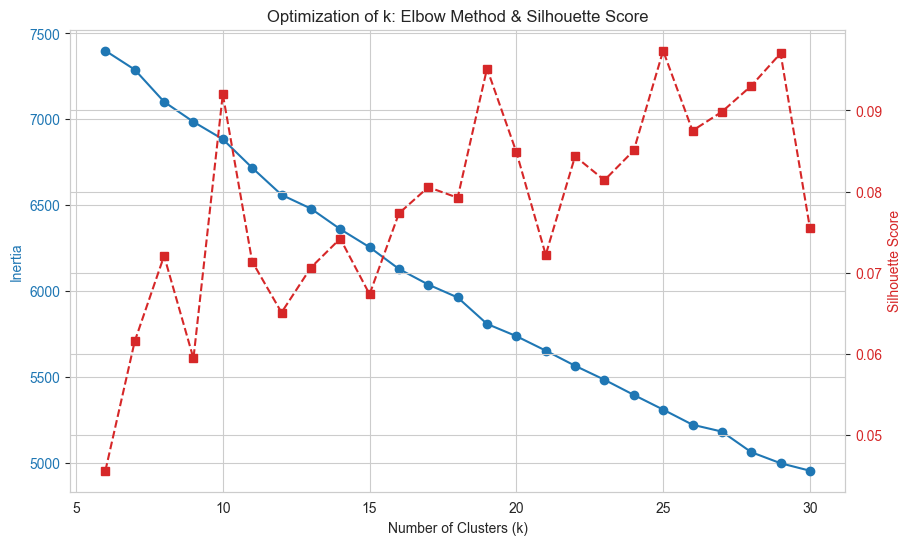

In [26]:

# We test k=6 to 20
# We use a SUBSET for Silhouette score because calculating it on 90k papers takes forever.
QUICK_TEST = False
MAX_CEILING = 31
ITER = 1 if QUICK_TEST else 5
k_range = range(6, MAX_CEILING)
inertias = []
sil_scores = []
sample_indices = np.random.choice(X_pca.shape[0], 15000, replace=False) # Test on 15k sample

print(f"Testing k values (6-{MAX_CEILING})...")
for k in k_range:
    temp_inertias = []
    temp_sil_scores = []
    for i in range(ITER):
        kmeans = KMeans(n_clusters=k, random_state=SAMPLE_SEED, n_init=5)
        labels = kmeans.fit_predict(X_pca)

        # Inertia (Elbow)
        temp_inertias.append(kmeans.inertia_)

        # Silhouette (Clustering Quality) - Closer to 1 is better
        score = silhouette_score(X_pca[sample_indices], labels[sample_indices])
        temp_sil_scores.append(score)

    inertias.append(np.mean(temp_inertias))
    sil_scores.append(np.mean(temp_sil_scores))

    print(f"k={k}: Silhouette={sil_scores[-1]:.4f}  Inertia={inertias[-1]:.4f}")

# Plot Results
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color='tab:blue')
ax1.plot(k_range, inertias, 'o-', color='tab:blue', label='Inertia')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Silhouette Score', color='tab:red')
ax2.plot(k_range, sil_scores, 's--', color='tab:red', label='Silhouette')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Optimization of k: Elbow Method & Silhouette Score')
plt.grid(True)
plt.savefig(f"{FIGURE_SAVE_PATH}/topic_clustering_optimal_k.png")
plt.show()

We start to evaluate all topic clusterings based on keywords for k values 6-30 in order too see when the topics start to get overly fragmented as well

In [27]:
import numpy as np
from sklearn.cluster import KMeans

START_K = 6
END_K = 31
N_INIT = 10

feature_names = tfidf.get_feature_names_out()

# Store topic outputs for later comparison
all_topic_models = {}

print("Running topic extraction for K = 6 to 30...\n")

for K in range(START_K, END_K):
    print("="*70)
    print(f"Clustering into {K} topics...")

    # Run KMeans
    kmeans = KMeans(
        n_clusters=K,
        random_state=SAMPLE_SEED,
        n_init=N_INIT
    )
    labels = kmeans.fit_predict(X_pca)

    # store labels so we don’t overwrite sampled_df each iteration
    all_topic_models[K] = {
        'labels': labels,
        'clusters': {}
    }

    print("Extracting top keywords for each topic...")

    for cluster_id in range(K):

        # indices belonging to this cluster
        cluster_indices = np.where(labels == cluster_id)[0]

        # compute average TF-IDF vector
        cluster_mean = X_tfidf[cluster_indices].mean(axis=0)
        cluster_mean_arr = np.asarray(cluster_mean).flatten()

        # top 10 keyword indices
        top_indices = cluster_mean_arr.argsort()[::-1][:10]
        top_keywords = [feature_names[i] for i in top_indices]

        # sample paper title
        sample_title = sampled_df.iloc[cluster_indices[0]]["title"]

        # Store structured info
        all_topic_models[K]['clusters'][cluster_id] = {
            'size': len(cluster_indices),
            'keywords': top_keywords,
            'sample_title': sample_title
        }

        # Print like your original style
        print(f"\n--- Cluster {cluster_id} ({len(cluster_indices)} papers) ---")
        print(f"Keywords: {', '.join(top_keywords)}")
        print(f"Sample Title: {sample_title}")

    print("="*70)
    print("\n")


Running topic extraction for K = 6 to 30...

Clustering into 6 topics...
Extracting top keywords for each topic...

--- Cluster 0 (5766 papers) ---
Keywords: language, languages, programming, program, programs, logic, semantics, natural language, natural, programming language
Sample Title: contextual definitions in nonextensional languages

--- Cluster 1 (6543 papers) ---
Keywords: network, networks, neural, wireless, routing, traffic, performance, nodes, neural networks, neural network
Sample Title: on the input impedance network error in operational amplifiers

--- Cluster 2 (2595 papers) ---
Keywords: graph, graphs, vertices, vertex, edge, edges, connected, abstract, planar, directed
Sample Title: on the exceptional case in a characterization of the arcs of a complete graph

--- Cluster 3 (27538 papers) ---
Keywords: linear, algorithms, problems, set, optimal, function, given, functions, finite, order
Sample Title: finite combinatory processes--formulation 1

--- Cluster 4 (4123 pap

Choose k with well differentiated, interpretable topics based on above cell

In [45]:
import numpy as np
from sklearn.cluster import KMeans

OPTIMAL_K = 19 # We chose this k for interpretability and from the above output

# Fit Final Model
print(f"Clustering into {OPTIMAL_K} topics...")
# Use X_pca for the clustering itself (efficient)
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=SAMPLE_SEED, n_init=10)
sampled_df['cluster'] = kmeans.fit_predict(X_pca)

# Interpret Clusters (Keyword Extraction)
print("Extracting top keywords for each topic...")

# We need the original TF-IDF vocabulary to convert numbers back to words
feature_names = tfidf.get_feature_names_out()

# Group papers by cluster
for i in range(OPTIMAL_K):
    # Get the indices of papers in this cluster
    cluster_indices = sampled_df[sampled_df['cluster'] == i].index

    # Calculate the AVERAGE TF-IDF vector for this cluster
    # (We use the X_tfidf matrix from Task 1, slicing by the cluster's rows)
    cluster_center = X_tfidf[cluster_indices].mean(axis=0)

    # Convert matrix to 1D array
    cluster_center_arr = np.asarray(cluster_center).flatten()

    # Get indices of the top 10 highest weighted words
    top_indices = cluster_center_arr.argsort()[::-1][:10]

    # Map indices to words
    top_keywords = [feature_names[ind] for ind in top_indices]

    print(f"\n--- Cluster {i} ({len(cluster_indices)} papers) ---")
    print(f"Keywords: {', '.join(top_keywords)}")
    # Show a sample title to verify
    print(f"Sample Title: {sampled_df[sampled_df['cluster'] == i]['title'].iloc[0]}")

Clustering into 19 topics...
Extracting top keywords for each topic...

--- Cluster 0 (14546 papers) ---
Keywords: problems, linear, algorithms, set, functions, finite, solution, function, optimal, given
Sample Title: finite combinatory processes--formulation 1

--- Cluster 1 (5404 papers) ---
Keywords: codes, signal, channel, error, noise, frequency, power, performance, estimation, filter
Sample Title: error-free coding

--- Cluster 2 (2055 papers) ---
Keywords: language, programming, natural language, natural, programming language, languages, program, semantics, programs, level
Sample Title: some programming techniques for the ermeth

--- Cluster 3 (2404 papers) ---
Keywords: graphs, graph, vertices, vertex, edge, edges, connected, abstract, planar, complete
Sample Title: on the exceptional case in a characterization of the arcs of a complete graph

--- Cluster 4 (1829 papers) ---
Keywords: parallel, algorithms, processors, memory, performance, processing, processor, parallel algorit

Visualize the clusters with new human-readable labels you might need to change the cluster_names list see above for the output result

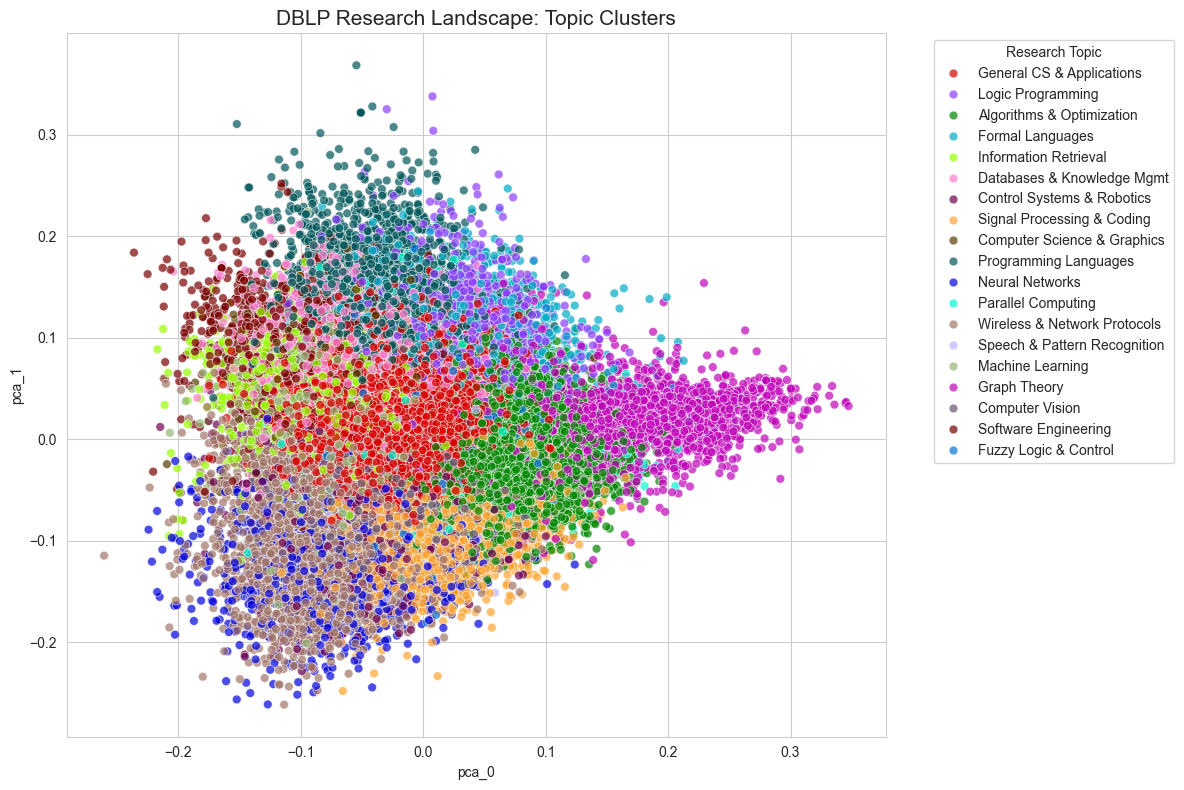

In [46]:
# Update cluster names based on the output we get above
cluster_names = {
    # --- THEORY & ALGORITHMS ---
    0: 'Algorithms & Optimization',      # problems, linear, algorithms, optimal, solution
    3: 'Graph Theory',                   # graphs, vertices, edge, planar, connected
    4: 'Parallel Computing',             # parallel, processors, algorithms, memory
    7: 'Logic Programming',              # logic, programs, modal, semantics, propositional
    16: 'Formal Languages',              # languages, grammars, context free, grammar

    # --- ARTIFICIAL INTELLIGENCE ---
    5: 'Machine Learning',               # learning, machine learning, training, classification
    6: 'Neural Networks',                # network, neural, neural networks, training
    11: 'Computer Vision',               # image, segmentation, color, motion, 3d
    14: 'Fuzzy Logic & Control',         # fuzzy, fuzzy logic, fuzzy sets, rules
    18: 'Speech & Pattern Recognition',  # speech recognition, speaker, acoustic, pattern

    # --- SYSTEMS & ENGINEERING ---
    1: 'Signal Processing & Coding',     # codes, signal, channel, error, noise, frequency
    8: 'Control Systems & Robotics',     # control, robot, adaptive, feedback, optimal control
    10: 'Wireless & Network Protocols',  # networks, routing, wireless, protocol, sensor, mobile
    15: 'Software Engineering',          # software engineering, process, hardware, testing

    # --- DATA & KNOWLEDGE ---
    2: 'Programming Languages',          # language, programming, natural language, semantics
    13: 'Information Retrieval',         # information retrieval, user, management, web, search
    17: 'Databases & Knowledge Mgmt',    # knowledge, database, query, relational, object oriented

    # --- INTERDISCIPLINARY ---
    9: 'Computer Science & Graphics',    # computer science, graphics, computer graphics, simulation

    # --- GENERAL/MIXED ---
    12: 'General CS & Applications'      # (The "Blob": performance, used, process, simulation, applications)
}

# For reference
hierarchy = {
    'Theory & Algorithms': [0, 3, 4, 7, 16],        # 5 clusters
    'Artificial Intelligence': [5, 6, 11, 14, 18],  # 5 clusters
    'Systems & Engineering': [1, 8, 10, 15],        # 4 clusters
    'Data & Knowledge': [2, 13, 17],                # 3 clusters
    'Interdisciplinary': [9],                        # 1 cluster
    'General': [12]                                  # 1 cluster (the blob)
}

# Apply the mapping
sampled_df['label'] = sampled_df['cluster'].map(cluster_names)

# Apply the mapping
sampled_df['label'] = sampled_df['cluster'].map(cluster_names)

# Apply mapping
sampled_df['label'] = sampled_df['cluster'].map(cluster_names)

# 3. Plot
palette = palette = cc.glasbey[:len(cluster_names)]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='pca_0',
    y='pca_1',
    hue='label',
    data=sampled_df,
    palette=palette,
    alpha=0.70,
    s=40             # Marker size
)
plt.title('DBLP Research Landscape: Topic Clusters', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Research Topic')
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/topic_clustering_pca.png")
plt.show()

Running t-SNE to visualize clusters (this takes a moment)...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 90191 samples in 0.016s...
[t-SNE] Computed neighbors for 90191 samples in 5.476s...
[t-SNE] Computed conditional probabilities for sample 1000 / 90191
[t-SNE] Computed conditional probabilities for sample 2000 / 90191
[t-SNE] Computed conditional probabilities for sample 3000 / 90191
[t-SNE] Computed conditional probabilities for sample 4000 / 90191
[t-SNE] Computed conditional probabilities for sample 5000 / 90191
[t-SNE] Computed conditional probabilities for sample 6000 / 90191
[t-SNE] Computed conditional probabilities for sample 7000 / 90191
[t-SNE] Computed conditional probabilities for sample 8000 / 90191
[t-SNE] Computed conditional probabilities for sample 9000 / 90191
[t-SNE] Computed conditional probabilities for sample 10000 / 90191
[t-SNE] Computed conditional probabilities for sample 11000 / 90191
[t-SNE] Computed conditional probabilities for sample 12

C:\Users\X0\AppData\Local\Temp\ipykernel_28108\594032256.py:15: UserWarning: The palette list has more values (32) than needed (19), which may not be intended.
  sns.scatterplot(


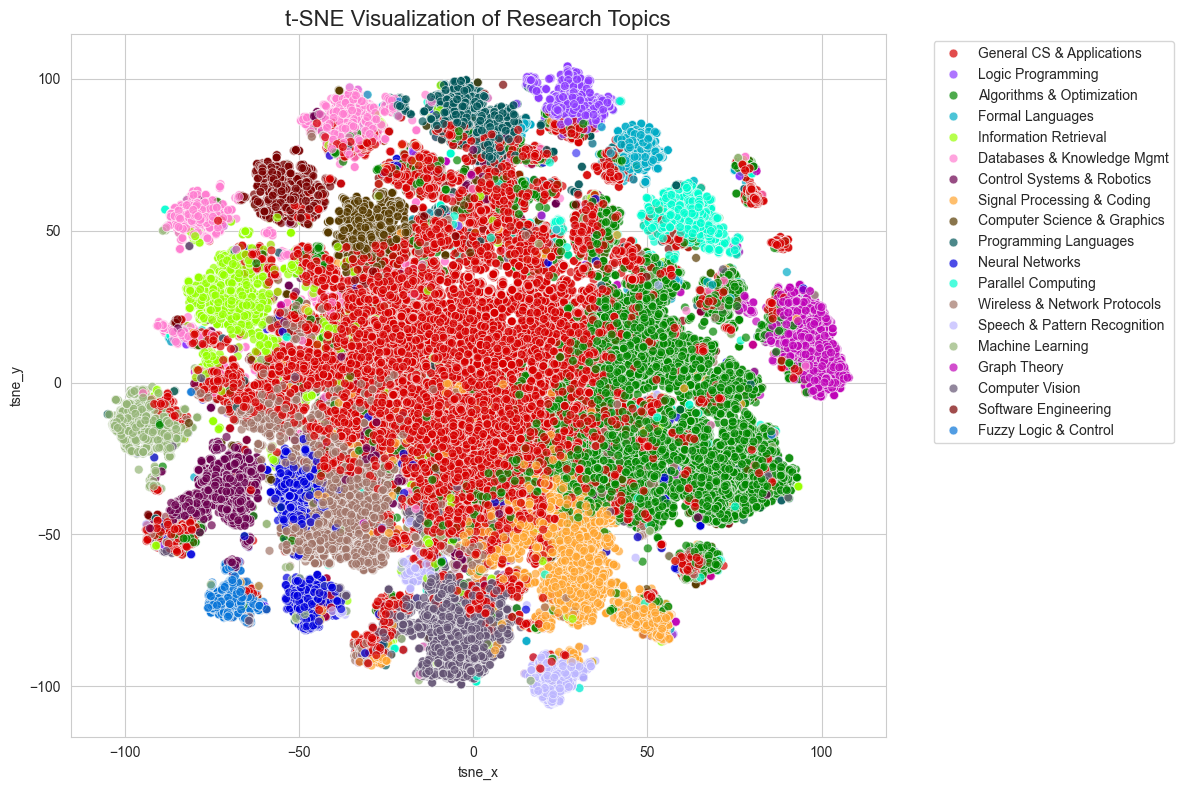

In [59]:
from sklearn.manifold import TSNE

print("Running t-SNE to visualize clusters (this takes a moment)...")

# We use the same X_pca data, but project it differently
tsne = TSNE(n_components=2, verbose=1, perplexity=40, random_state=SAMPLE_SEED)
tsne_results = tsne.fit_transform(X_pca)

# Add t-SNE results to the dataframe
sampled_df['tsne_x'] = tsne_results[:, 0]
sampled_df['tsne_y'] = tsne_results[:, 1]

# Plotting the t-SNE result
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_x',
    y='tsne_y',
    hue='label',
    data=sampled_df,
    palette=palette,
    alpha=0.7,
    s=40,
    legend='full'
)

plt.title('t-SNE Visualization of Research Topics', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/topic_clustering_t-SNE.png")
plt.show()

Checkpoint save and load dataset

In [103]:
save_split_dataframe(sampled_df, DATASET_PATH, DATASET_SAMPLE_NAME, n_parts = 10)

Saved rows [0:22548) to ./datasets\reproducible_dataset_part00.pkl
Saved rows [22548:45096) to ./datasets\reproducible_dataset_part01.pkl
Saved rows [45096:67644) to ./datasets\reproducible_dataset_part02.pkl
Saved rows [67644:90191) to ./datasets\reproducible_dataset_part03.pkl


In [ ]:
sampled_df = load_split_dataframe(DATASET_PATH, DATASET_SAMPLE_NAME)

Tackling the blob (The big cluster) to see if we can subdivide it. First we start by trying to find the optimal k

Extracting Cluster 12 (the blob) for re-clustering...
Blob size: 34806 papers
Shape - TF-IDF: (34806, 5000), PCA: (34806, 50)

Testing k values for blob clustering...
k=5: Silhouette=0.0940  Inertia=1382.8678
k=6: Silhouette=0.0989  Inertia=1347.0449
k=7: Silhouette=0.0968  Inertia=1289.8005
k=8: Silhouette=0.1068  Inertia=1250.7393
k=9: Silhouette=0.1023  Inertia=1216.5739
k=10: Silhouette=0.1008  Inertia=1180.0700
k=11: Silhouette=0.1009  Inertia=1150.7966
k=12: Silhouette=0.1034  Inertia=1115.7667
k=13: Silhouette=0.1073  Inertia=1086.4778
k=14: Silhouette=0.1113  Inertia=1056.8738
k=15: Silhouette=0.1001  Inertia=1036.3715


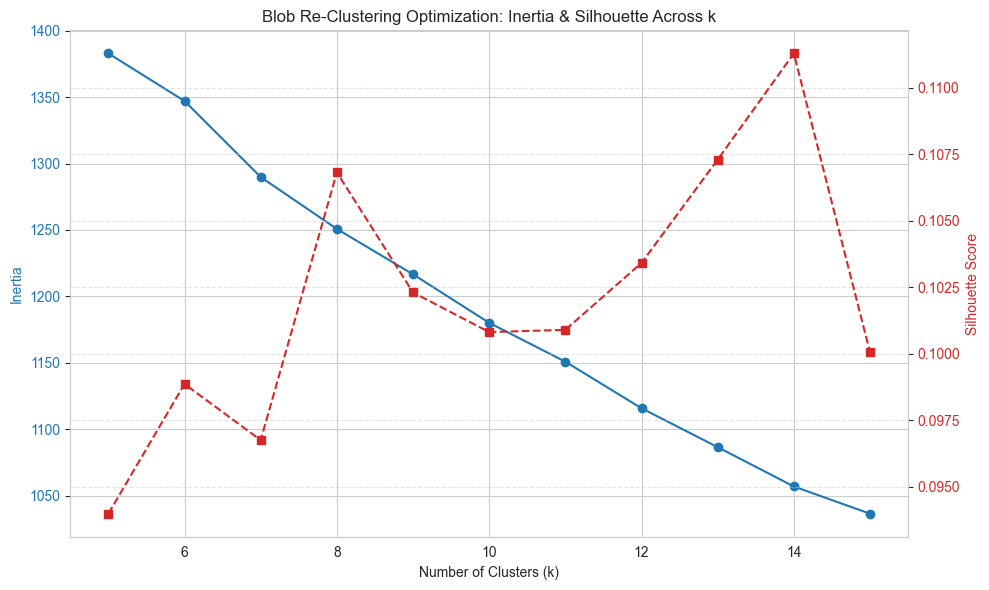

In [34]:
# Extract just the blob (Cluster)
print("Extracting Cluster 12 (the blob) for re-clustering...")
blob_mask = sampled_df['cluster'] == 12
blob_df = sampled_df[blob_mask].copy()
blob_indices = blob_df.index

# Get the corresponding TF-IDF and PCA representations
X_tfidf_blob = X_tfidf[blob_indices]
X_pca_blob = X_pca[blob_indices]

print(f"Blob size: {len(blob_df)} papers")
print(f"Shape - TF-IDF: {X_tfidf_blob.shape}, PCA: {X_pca_blob.shape}")

# Test different k values for the blob
print("\nTesting k values for blob clustering...")
from sklearn.metrics import silhouette_score

blob_k_range = range(5, 16)  # Test k=5 to k=15
blob_scores = []

for k in blob_k_range:
    kmeans_test = KMeans(n_clusters=k, random_state=SAMPLE_SEED, n_init=10)
    labels = kmeans_test.fit_predict(X_pca_blob)

    silhouette = silhouette_score(X_pca_blob, labels)
    inertia = kmeans_test.inertia_

    blob_scores.append({'k': k, 'silhouette': silhouette, 'inertia': inertia})
    print(f"k={k}: Silhouette={silhouette:.4f}  Inertia={inertia:.4f}")


# Plot the results
ks = [d['k'] for d in blob_scores]
inertias = [d['inertia'] for d in blob_scores]
silhouettes = [d['silhouette'] for d in blob_scores]

fig, ax1 = plt.subplots(figsize=(10, 6))
# Inertia curve
ax1.set_xlabel("Number of Clusters (k)")
ax1.set_ylabel("Inertia", color="tab:blue")
ax1.plot(ks, inertias, "o-", color="tab:blue", label="Inertia")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Silhouette curve (secondary axis)
ax2 = ax1.twinx()
ax2.set_ylabel("Silhouette Score", color="tab:red")
ax2.plot(ks, silhouettes, "s--", color="tab:red", label="Silhouette")
ax2.tick_params(axis="y", labelcolor="tab:red")

# Title & presentation
plt.title("Blob Re-Clustering Optimization: Inertia & Silhouette Across k")
plt.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/topic_clustering_blob_optimal_k.png", dpi=300)
plt.show()

Choose optimal K for the blob (big cluster) based on the output above

In [73]:
# Choose optimal k for blob (pick based on output above)
BLOB_K = 14

print(f"Re-clustering blob into {BLOB_K} sub-topics...")
print(f"{'='*70}\n")

# Fit final model on blob
kmeans_blob = KMeans(n_clusters=BLOB_K, random_state=SAMPLE_SEED, n_init=10)
blob_df['sub_cluster'] = kmeans_blob.fit_predict(X_pca_blob)

# Extract keywords for blob sub-clusters
print("Extracting top keywords for each blob sub-topic...")
feature_names = tfidf.get_feature_names_out()

for i in range(BLOB_K):
    # Get indices within the blob dataframe
    sub_cluster_mask = blob_df['sub_cluster'] == i
    sub_cluster_df = blob_df[sub_cluster_mask]

    # Get the actual indices in the original data
    sub_cluster_indices = sub_cluster_df.index

    # Calculate average TF-IDF vector for this sub-cluster
    cluster_center = X_tfidf[sub_cluster_indices].mean(axis=0)
    cluster_center_arr = np.asarray(cluster_center).flatten()

    # Get top 10 keywords
    top_indices = cluster_center_arr.argsort()[::-1][:10]
    top_keywords = [feature_names[ind] for ind in top_indices]

    print(f"\n--- Blob Sub-Cluster {i} ({len(sub_cluster_df)} papers) ---")
    print(f"Keywords: {', '.join(top_keywords)}")
    print(f"Sample Title: {sub_cluster_df['title'].iloc[0]}")



Re-clustering blob into 14 sub-topics...

Extracting top keywords for each blob sub-topic...

--- Blob Sub-Cluster 0 (13521 papers) ---
Keywords: note, abstract, semantics, calculus, editor, reasoning, proof, certification, review, theorem
Sample Title: toward a calculus of concepts

--- Blob Sub-Cluster 1 (787 papers) ---
Keywords: simulation, modeling, event, discrete event, performance, discrete, process, manufacturing, used, agent
Sample Title: digital computers for real-time simulation

--- Blob Sub-Cluster 2 (796 papers) ---
Keywords: test, fault, testing, faults, circuits, generation, test generation, coverage, tests, circuit
Sample Title: a test for the existence of tautologies according to many-valued truth-tables

--- Blob Sub-Cluster 3 (1165 papers) ---
Keywords: user, interface, users, interactive, user interface, virtual, interaction, interfaces, environment, user interfaces
Sample Title: system engineering in an industrial environment

--- Blob Sub-Cluster 4 (655 papers) 

Update original dataframe with new labels

In [74]:
# Update original dataframe with new labels without destroying the original mini clusters we found
sampled_df[f'blob_k{BLOB_K}'] = np.nan
sampled_df.loc[blob_indices, f'blob_k{BLOB_K}'] = blob_df['sub_cluster']

Now we plot name new subclusters found in the blob and then merge both the previous cluster and the blob sub clusters

In [75]:
blob_subcluster_names = {
    0:  "Logic/Proof & Semantics Core",
    1:  "Discrete-Event Simulation & Modeling",
    2:  "Hardware Testing & Fault Diagnosis",
    3:  "User Interfaces & HCI",
    4:  "Web Search & Semantic Web Services",
    5:  "Memory & Cache Architectures",
    6:  "Decision Support & Business Processes",
    7:  "Mobile Robotics & Navigation",
    8:  "High-Performance Architectures & Scheduling",
    9:  "Extended Abstracts & Protocols",
    10: "Type & Recursion Theory",
    11: "Program Verification & Correctness",
    12: "Distributed Systems & Communication",
    13: "Detection, Structure & Object/Video Methods",
}

def assign_topic_label(row):
    global_id = row['cluster']
    blob_id = row['blob_k14']

    # If it's NOT in the blob, use the global name
    if global_id != 12:
        return cluster_names.get(global_id, f"Cluster {global_id}")

    # If it IS in the blob, and we have subcluster info, use refined name
    if pd.notna(blob_id):
        blob_id = int(blob_id)
        return blob_subcluster_names.get(blob_id, f"Blob Subtopic {blob_id}")

    # Fallback (should basically never happen)
    return "General CS & Applications (Unrefined)"

sampled_df['topic_label'] = sampled_df.apply(assign_topic_label, axis=1)

Checkpoint save and load sampled dataset

In [105]:
save_split_dataframe(sampled_df, DATASET_PATH, DATASET_SAMPLE_NAME, n_parts = 10)

Saved rows [0:9020) to ./datasets\reproducible_dataset_part00.pkl
Saved rows [9020:18040) to ./datasets\reproducible_dataset_part01.pkl
Saved rows [18040:27060) to ./datasets\reproducible_dataset_part02.pkl
Saved rows [27060:36080) to ./datasets\reproducible_dataset_part03.pkl
Saved rows [36080:45100) to ./datasets\reproducible_dataset_part04.pkl
Saved rows [45100:54120) to ./datasets\reproducible_dataset_part05.pkl
Saved rows [54120:63140) to ./datasets\reproducible_dataset_part06.pkl
Saved rows [63140:72160) to ./datasets\reproducible_dataset_part07.pkl
Saved rows [72160:81180) to ./datasets\reproducible_dataset_part08.pkl
Saved rows [81180:90191) to ./datasets\reproducible_dataset_part09.pkl


In [ ]:
sampled_df = load_split_dataframe(DATASET_PATH, DATASET_SAMPLE_NAME)

In [94]:
sampled_df.head(10)

year abstract              authors  n_citation  \
0  1936                 [W. V. Quine]          19   
1  1936           [Frederic B. Fitch]          24   
2  1936                [Emil L. Post]         367   
3  1936           [J. Barkley Rosser]           1   
4  1936               [Alonzo Church]         150   
5  1936               [Alonzo Church]         949   
6  1937                [A. M. Turing]         552   
7  1937                [A. M. Turing]           4   
8  1937             [B. A. Bernstein]           1   
9  1937            [Haskell B. Curry]           6   

                               references  \
0                                     NaN   
1                                      []   
2                                      []   
3                                     NaN   
4  [c45bdb20-3d36-4d7d-8a83-203e3d3bff9e]   
5                                      []   
6                                      []   
7                                      []   
8                                      []   
9                                     NaN   

                                               title  \
0                      toward a calculus of concepts   
1  a system of formal logic without an analogue t...   
2        finite combinatory processes--formulation 1   
3      constructibility as a criterion for existence   
4   correction to a note on the entscheidungsproblem   
5                 a note on the entscheidungsproblem   
6                   computability and λ-definability   
7                   the þ-function in λ-k-conversion   
8  remark on nicod's reduction of principia mathe...   
9  on the use of dots as brackets in logical expr...   

                       venue                                    id  \
0  Journal of Symbolic Logic  566fc941-6ba6-41ab-b579-ad3d7fe4ca27   
1  Journal of Symbolic Logic  62c68236-b9e5-44dd-b299-e0d03c3e7bf4   
2  Journal of Symbolic Logic  e254cbb5-e369-49dc-97a2-4d60eaea27dd   
3  Journal of Symbolic Logic  8581f824-2333-4b5f-b277-a4020281a7f8   
4  Journal of Symbolic Logic  c5c32b04-0a67-4cd6-b135-3f65ab87e33b   
5  Journal of Symbolic Logic  c45bdb20-3d36-4d7d-8a83-203e3d3bff9e   
6  Journal of Symbolic Logic  0ae42956-0f17-4fd8-9453-baf2d0961c1a   
7  Journal of Symbolic Logic  2c4c81e4-53d5-43d9-b82f-a230e22c2378   
8  Journal of Symbolic Logic  fb61c692-822a-4541-9986-6ad4bf485251   
9  Journal of Symbolic Logic  41f5e18d-db3d-4649-8e2e-c9f3d3e36196   

                                                text  num_authors  ...  \
0                     Toward a calculus of concepts             1  ...   
1  A System of Formal Logic without an Analogue t...            1  ...   
2       Finite Combinatory Processes--Formulation 1             1  ...   
3     Constructibility as a Criterion for Existence             1  ...   
4  Correction to a Note on the Entscheidungsproblem             1  ...   
5                A Note on the Entscheidungsproblem             1  ...   
6                  Computability and λ-definability             1  ...   
7                  The þ-function in λ-K-conversion             1  ...   
8  Remark on Nicod's Reduction of Principia Mathe...            1  ...   
9  On the Use of Dots as Brackets in Logical Expr...            1  ...   

     pca_46    pca_47    pca_48    pca_49  cluster                      label  \
0  0.002952  0.017808  0.008910 -0.010326       12  General CS & Applications   
1  0.019213  0.006718 -0.022645 -0.019774        7          Logic Programming   
2 -0.012288 -0.048536  0.038909  0.053052        0  Algorithms & Optimization   
3 -0.000098  0.001151  0.002429 -0.010975       12  General CS & Applications   
4 -0.033541 -0.083212  0.039810 -0.026251       12  General CS & Applications   
5 -0.053481 -0.105636  0.066998 -0.049147       12  General CS & Applications   
6  0.003440 -0.000305 -0.001626 -0.000838       12  General CS & Applications   
7  0.049571 -0.020171  0.016983  0.058341        0  Algorithms & Optimiz

Plot PCA

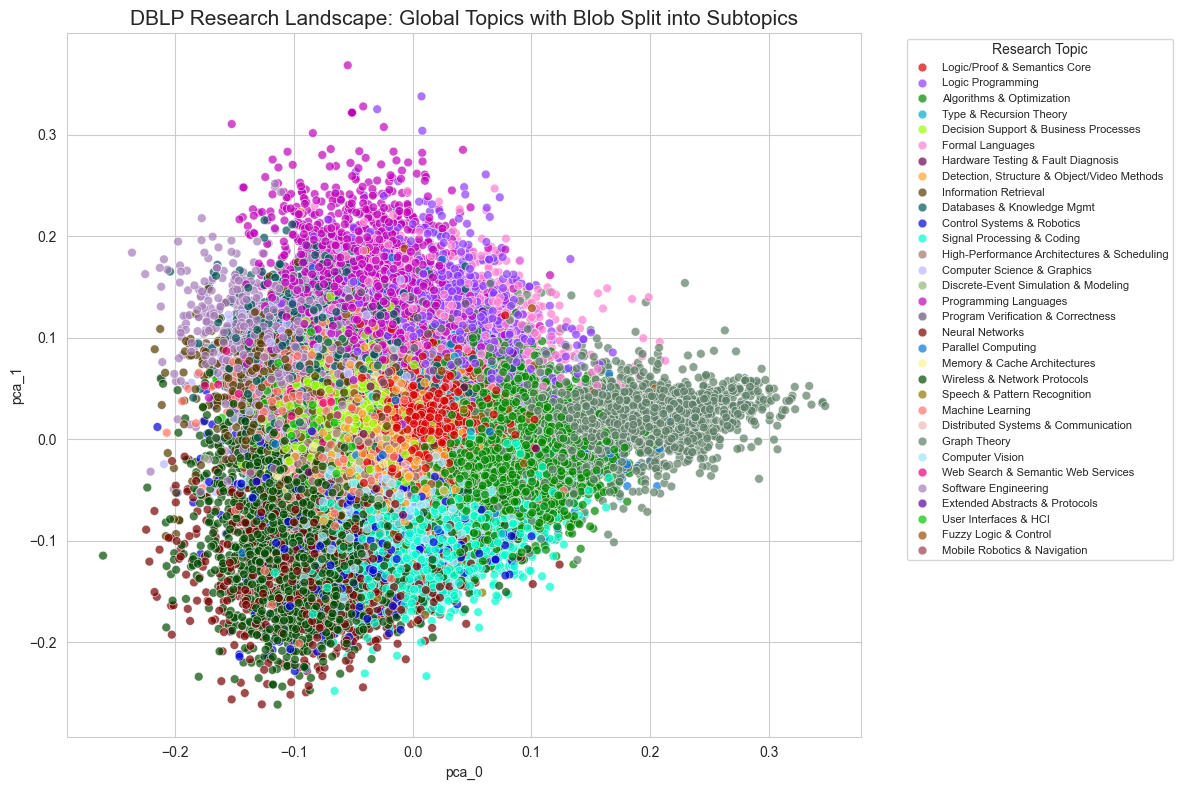

In [77]:
unique_labels = sampled_df['topic_label'].unique()
palette = cc.glasbey[:len(unique_labels)]

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='pca_0',
    y='pca_1',
    hue='topic_label',
    data=sampled_df,
    palette=palette,
    alpha=0.7,
    s=40,
)
plt.title('DBLP Research Landscape: Global Topics with Blob Split into Subtopics', fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Research Topic', fontsize=8)
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/topic_clustering_pca_refined.png", dpi=300)
plt.show()


T-SNE with refined topics

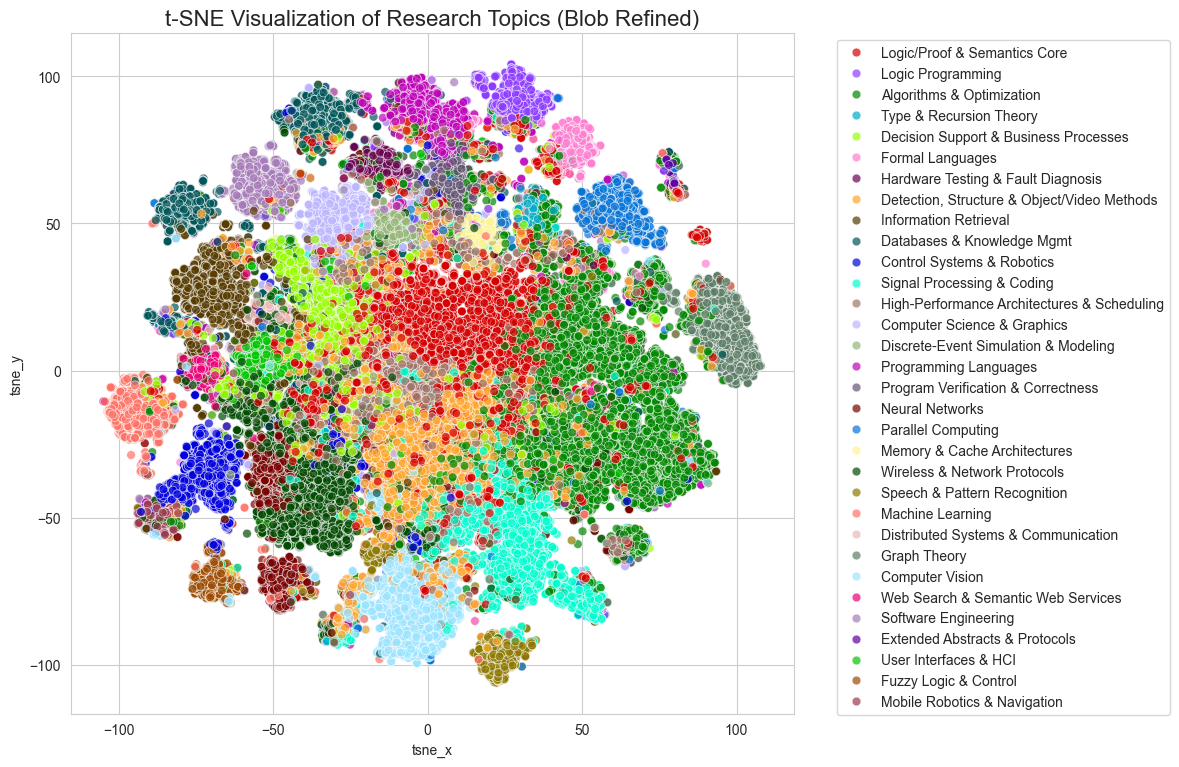

In [78]:
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_x',
    y='tsne_y',
    hue='topic_label',
    data=sampled_df,
    palette=palette,
    alpha=0.7,
    s=40,
    legend='full'
)
plt.title('t-SNE Visualization of Research Topics (Blob Refined)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_PATH}/topic_clustering_tsne_refined.png")
plt.show()


## Task 3: Temporal Trend Analysis

In [15]:
# identify PCA columns
pca_cols = [col for col in sampled_df.columns if col.startswith('pca_')]

# clustering using KMeans
OPTIMAL_K = 8  # Choose an optimal K based on prior analysis
kmeans = KMeans(n_clusters=OPTIMAL_K, random_state=42, n_init=10)
sampled_df['cluster'] = kmeans.fit_predict(sampled_df[pca_cols])

In [16]:
# map cluster names based on prior interpretation
cluster_names = {
    0: 'Numerical Computing',      # matrix, inversion, polynomial
    1: 'General Modeling & Logic', # (The large catch-all cluster)
    2: 'Robotics & Control',       # robot, controller, manipulator
    3: 'Optimization & Theory',    # linear programming, equations
    4: 'Software & Info Systems',  # language, software, user, design
    5: 'Graph Theory',             # vertices, edge, connected
    6: 'Networking & Wireless',    # wireless, routing, protocol
    7: 'Editorial/Historical'      # letters to editor, algol, acm
}

sampled_df['label'] = sampled_df['cluster'].map(cluster_names)

In [17]:
# build temporal trend data
trend = sampled_df.groupby(['year', 'label']).size().rename('count').reset_index()

# normalize by year totals
year_totals = trend.groupby('year')['count'].sum().rename('year_total')
trend = trend.merge(year_totals, on='year')
trend["share"] = trend["count"] / trend["year_total"]

/var/folders/75/qzfw3nr90j3_7wzdxhpqh5vm0000gn/T/ipykernel_35894/3056517717.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  trend = sampled_df.groupby(['year', 'label']).size().rename('count').reset_index()
/var/folders/75/qzfw3nr90j3_7wzdxhpqh5vm0000gn/T/ipykernel_35894/3056517717.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_totals = trend.groupby('year')['count'].sum().rename('year_total')


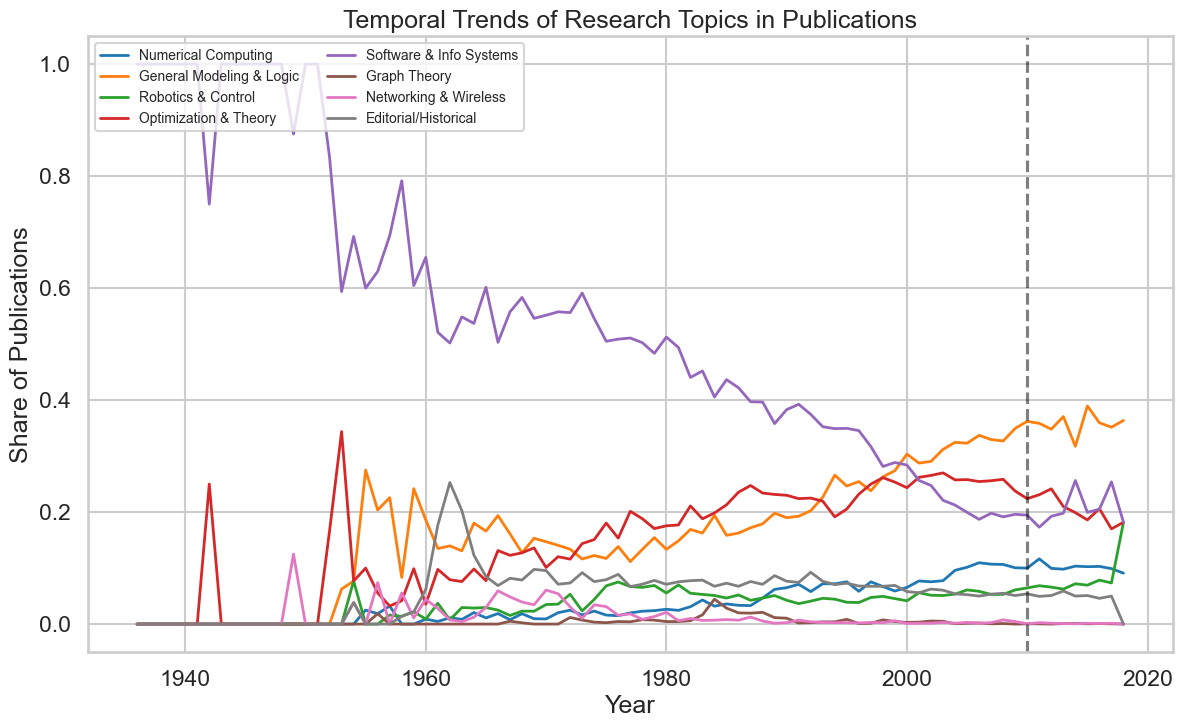

<Figure size 640x480 with 0 Axes>

In [18]:
# visualization of trends
sns.set(style="whitegrid", context="talk", palette="tab10")

plt.figure(figsize=(14, 8))
for label in cluster_names.values():
    sub = trend[trend["label"] == label].sort_values("year")
    plt.plot(sub["year"], sub["share"], label=label, linewidth=2)

plt.axvline(2010, color="k", linestyle="--", alpha=0.5)
plt.title("Temporal Trends of Research Topics in Publications")
plt.xlabel("Year")
plt.ylabel("Share of Publications")
plt.legend(loc="upper left", ncol=2, fontsize=10, frameon=True)
plt.show()
plt.savefig(f"{FIGURE_SAVE_PATH}/temporal_trends.png")
plt.show()

In [ ]:
# summary table for rise and fall of each topic over time
summary = (
    trend.assign(period=trend['year'].apply(lambda y: 'Pre-2010' if int(y) < 2010 else 'Post-2010'))
    .groupby(['label', 'period'])['share']
    .mean()
    .unstack()
    .reset_index()
)

print(summary)

period                     label  Post-2010  Pre-2010
0           Editorial/Historical   0.045611  0.055779
1       General Modeling & Logic   0.357848  0.152326
2                   Graph Theory   0.000556  0.004317
3          Networking & Wireless   0.001111  0.014006
4            Numerical Computing   0.101434  0.031690
5          Optimization & Theory   0.205480  0.143787
6             Robotics & Control   0.081869  0.032248
7        Software & Info Systems   0.206091  0.565847


## Task 4: Predictive Modeling (Classification)

## Task 5: Network Analysis